In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [24]:
df = pd.read_csv("Online Retail.csv", encoding='ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [25]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   541909 non-null  int64  
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 33.1+ MB


InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
dtype: int64

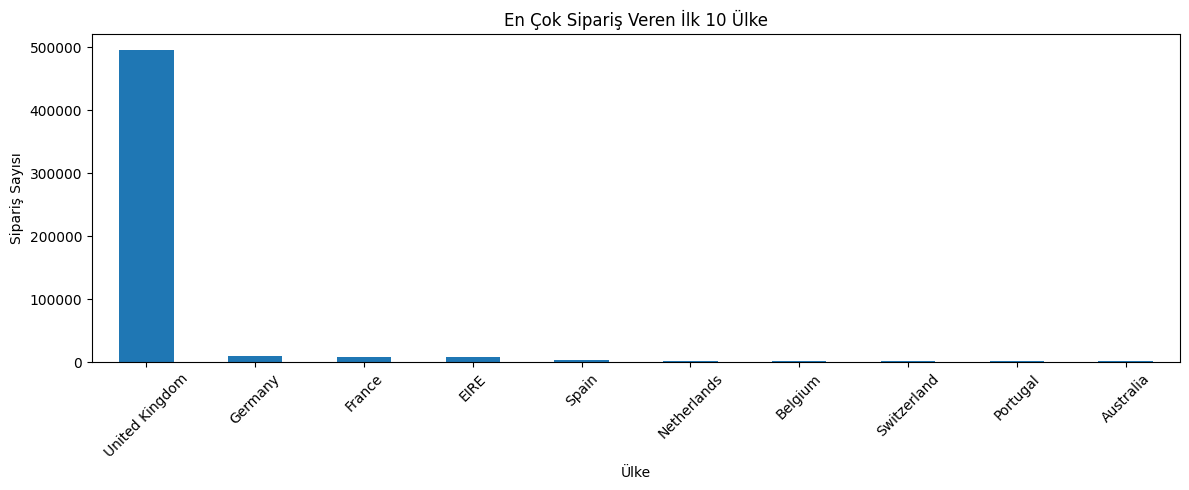

In [26]:
plt.figure(figsize=(12, 5))
df['Country'].value_counts().head(10).plot(kind='bar')
plt.title("En Çok Sipariş Veren İlk 10 Ülke")
plt.xlabel("Ülke")
plt.ylabel("Sipariş Sayısı")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
df = df.dropna(subset=['CustomerID'])


In [28]:
df = df.dropna(subset=['Description'])


In [29]:
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]


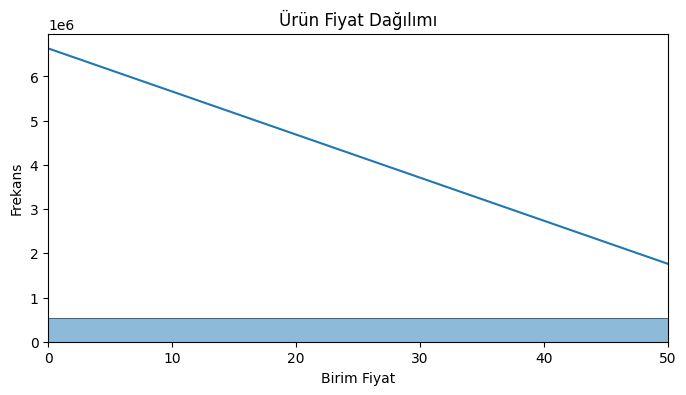

In [30]:
plt.figure(figsize=(8, 4))
sns.histplot(df['UnitPrice'], bins=100, kde=True)
plt.xlim(0, 50)  # Aykırıları hariç tutmak için
plt.title("Ürün Fiyat Dağılımı")
plt.xlabel("Birim Fiyat")
plt.ylabel("Frekans")
plt.show()


In [31]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [32]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


C:\Users\cevik\AppData\Local\Temp\ipykernel_26596\4207968351.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_orders = df.set_index('InvoiceDate').resample('M')['InvoiceNo'].nunique()


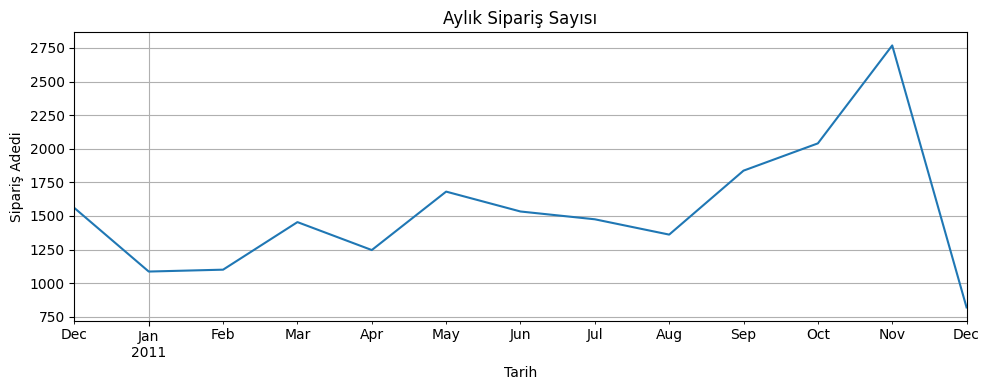

In [33]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])  # emin olmak için tekrar yazabilirsin
monthly_orders = df.set_index('InvoiceDate').resample('M')['InvoiceNo'].nunique()

plt.figure(figsize=(10, 4))
monthly_orders.plot()
plt.title("Aylık Sipariş Sayısı")
plt.xlabel("Tarih")
plt.ylabel("Sipariş Adedi")
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
last_date = df['InvoiceDate'].max()

customer_df = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',
    'Quantity': 'sum',
    'TotalPrice': ['sum', 'mean'],
    'InvoiceDate': lambda x: (last_date - x.max()).days
})
customer_df.columns = ['InvoiceCount', 'TotalQuantity', 'TotalSpending', 'AvgSpending', 'Recency']
customer_df = customer_df.reset_index()


In [35]:
cutoff_date = pd.to_datetime("2011-12-01")

# Eğitim için önceki kayıtlar
df_before = df[df['InvoiceDate'] < cutoff_date]

# Etiketleme için sonraki kayıtlar
df_after = df[df['InvoiceDate'] >= cutoff_date]


In [36]:
features_df = df_before.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',
    'Quantity': 'sum',
    'TotalPrice': ['sum', 'mean'],
    'InvoiceDate': lambda x: (cutoff_date - x.max()).days
})
features_df.columns = ['InvoiceCount', 'TotalQuantity', 'TotalSpending', 'AvgSpending', 'Recency']
features_df = features_df.reset_index()


In [37]:
# cutoff sonrası alışveriş yapan müşteriler
repeat_customers = df_after['CustomerID'].unique()

# Her müşteri için alışveriş yapıp yapmadığı bilgisi
features_df['Reordered'] = features_df['CustomerID'].isin(repeat_customers).astype(int)


In [38]:
features_df.head()


,CustomerID,InvoiceCount,TotalQuantity,TotalSpending,AvgSpending,Recency,Reordered
0,12346,1,74215,77183.60,77183.600000,316,0
1,12347,6,2266,4085.18,23.889942,30,1
2,12348,4,2341,1797.24,57.975484,66,0
3,12349,1,631,1757.55,24.076027,9,0
4,12350,1,197,334.40,19.670588,301,0


In [39]:
from sklearn.model_selection import train_test_split

X = features_df[['InvoiceCount', 'TotalQuantity', 'TotalSpending', 'AvgSpending', 'Recency']]
y = features_df['Reordered']


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

In [42]:
y_pred = model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))


Confusion Matrix:
 [[658  82]
 [ 93  27]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.88       740
           1       0.25      0.23      0.24       120

    accuracy                           0.80       860
   macro avg       0.56      0.56      0.56       860
weighted avg       0.79      0.80      0.79       860

Accuracy Score: 0.7965116279069767


In [43]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("Accuracy Score:", accuracy_score(y_test, y_pred_rf))


Confusion Matrix:
 [[726  14]
 [102  18]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       740
           1       0.56      0.15      0.24       120

    accuracy                           0.87       860
   macro avg       0.72      0.57      0.58       860
weighted avg       0.83      0.87      0.83       860

Accuracy Score: 0.8651162790697674


In [44]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [46]:
y_pred_rf = rf_model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("Accuracy Score:", accuracy_score(y_test, y_pred_rf))


Confusion Matrix:
 [[642 130]
 [ 94 623]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.83      0.85       772
           1       0.83      0.87      0.85       717

    accuracy                           0.85      1489
   macro avg       0.85      0.85      0.85      1489
weighted avg       0.85      0.85      0.85      1489

Accuracy Score: 0.8495634654130289


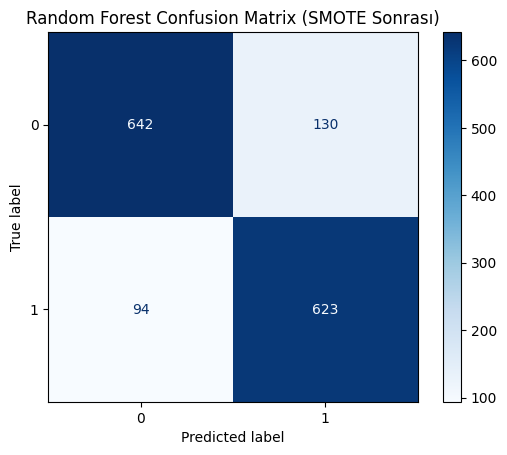

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, cmap='Blues')
plt.title("Random Forest Confusion Matrix (SMOTE Sonrası)")
plt.show()


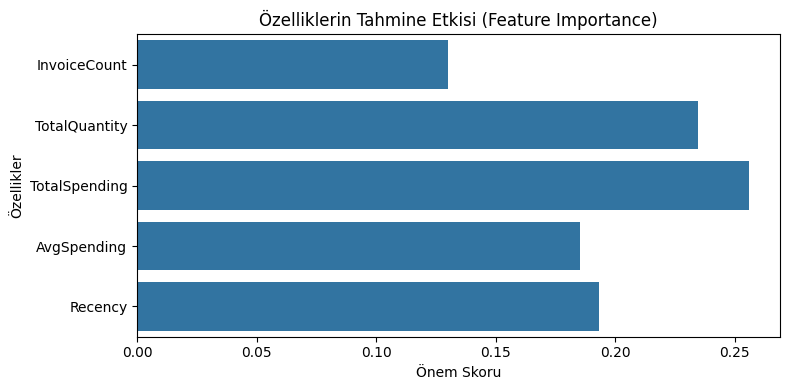

In [48]:
importances = rf_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 4))
sns.barplot(x=importances, y=feature_names)
plt.title("Özelliklerin Tahmine Etkisi (Feature Importance)")
plt.xlabel("Önem Skoru")
plt.ylabel("Özellikler")
plt.tight_layout()
plt.show()
